In this notebook I'll be working on the [MTS Library Dataset](https://www.kaggle.com/sharthz23/mts-library), which contains data about book-reading interactions and associated metadata (such as book genres and user demographics). I'll build a hybrid recommendation system using LightFM, combining:

- implicit feedback (interaction matrix)
- content features (book attributes, user profiles)

The goal of this project is to explore how metadata can improve recommendations in content-based methods.

In [1]:
!pip install lightfm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, csr_matrix
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preprocessing

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML/projects/lightfm/data/interactions.csv')
df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


In [5]:
df.shape

(1533078, 5)

In [6]:
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# remove duplicates, keeping the last record only
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

In [7]:
df.shape

(1532998, 5)

In [8]:
USER_COL = 'user_id'
ITEM_COL = 'item_id'
RATING_COL = 'rating'
PROGRESS_COL = 'progress'

In [9]:
print(f'Total records: {df.shape[0]}')
print(f'Unique users: {df[USER_COL].nunique()}')
print(f'Unique items: {df[ITEM_COL].nunique()}')

Total records: 1532998
Unique users: 151600
Unique items: 59599


In [10]:
# Check for NaNs
# Explicit ratings are mostly absent. We will treat this as an implicit feedback task, using progress data as target
df.isna().sum()

,0
user_id,0
item_id,0
progress,0
rating,1247661
start_date,0


In [11]:
print(f'Num ratings: {(~df[RATING_COL].isna()).sum()}')
print(f'Num progress stamps: {(~df[PROGRESS_COL].isna()).sum()}')

Num ratings: 285337
Num progress stamps: 1532998


In [12]:
user_count = df.groupby(USER_COL)[ITEM_COL].count()

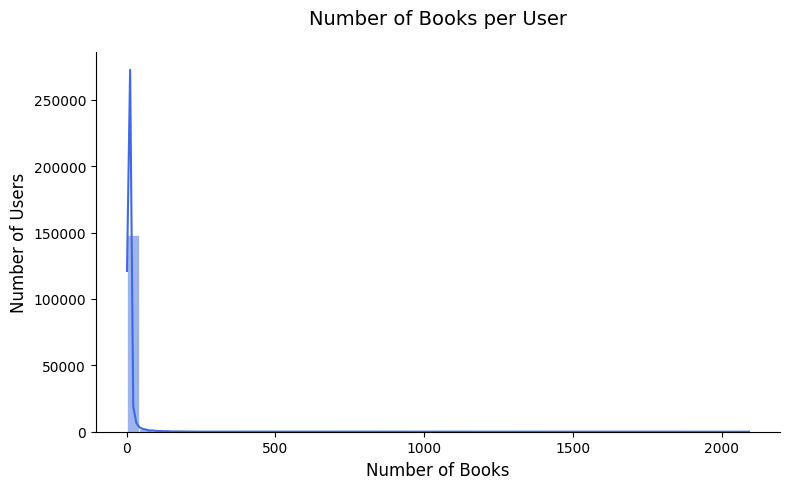

In [13]:
plt.figure(figsize=(8, 5))
plt.rcParams['figure.dpi'] = 600
ax = sns.histplot(user_count,
                 bins=50,
                 color='royalblue',
                 kde=True,
                 edgecolor='white',
                 linewidth=0.5)

plt.title('Number of Books per User', fontsize=14, pad=20)
plt.xlabel('Number of Books', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [14]:
user_count.describe()

,item_id
count,151600.000000
mean,10.112124
std,20.922963
min,1.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,2091.000000


In [15]:
item_count = df.groupby(ITEM_COL)[USER_COL].count()

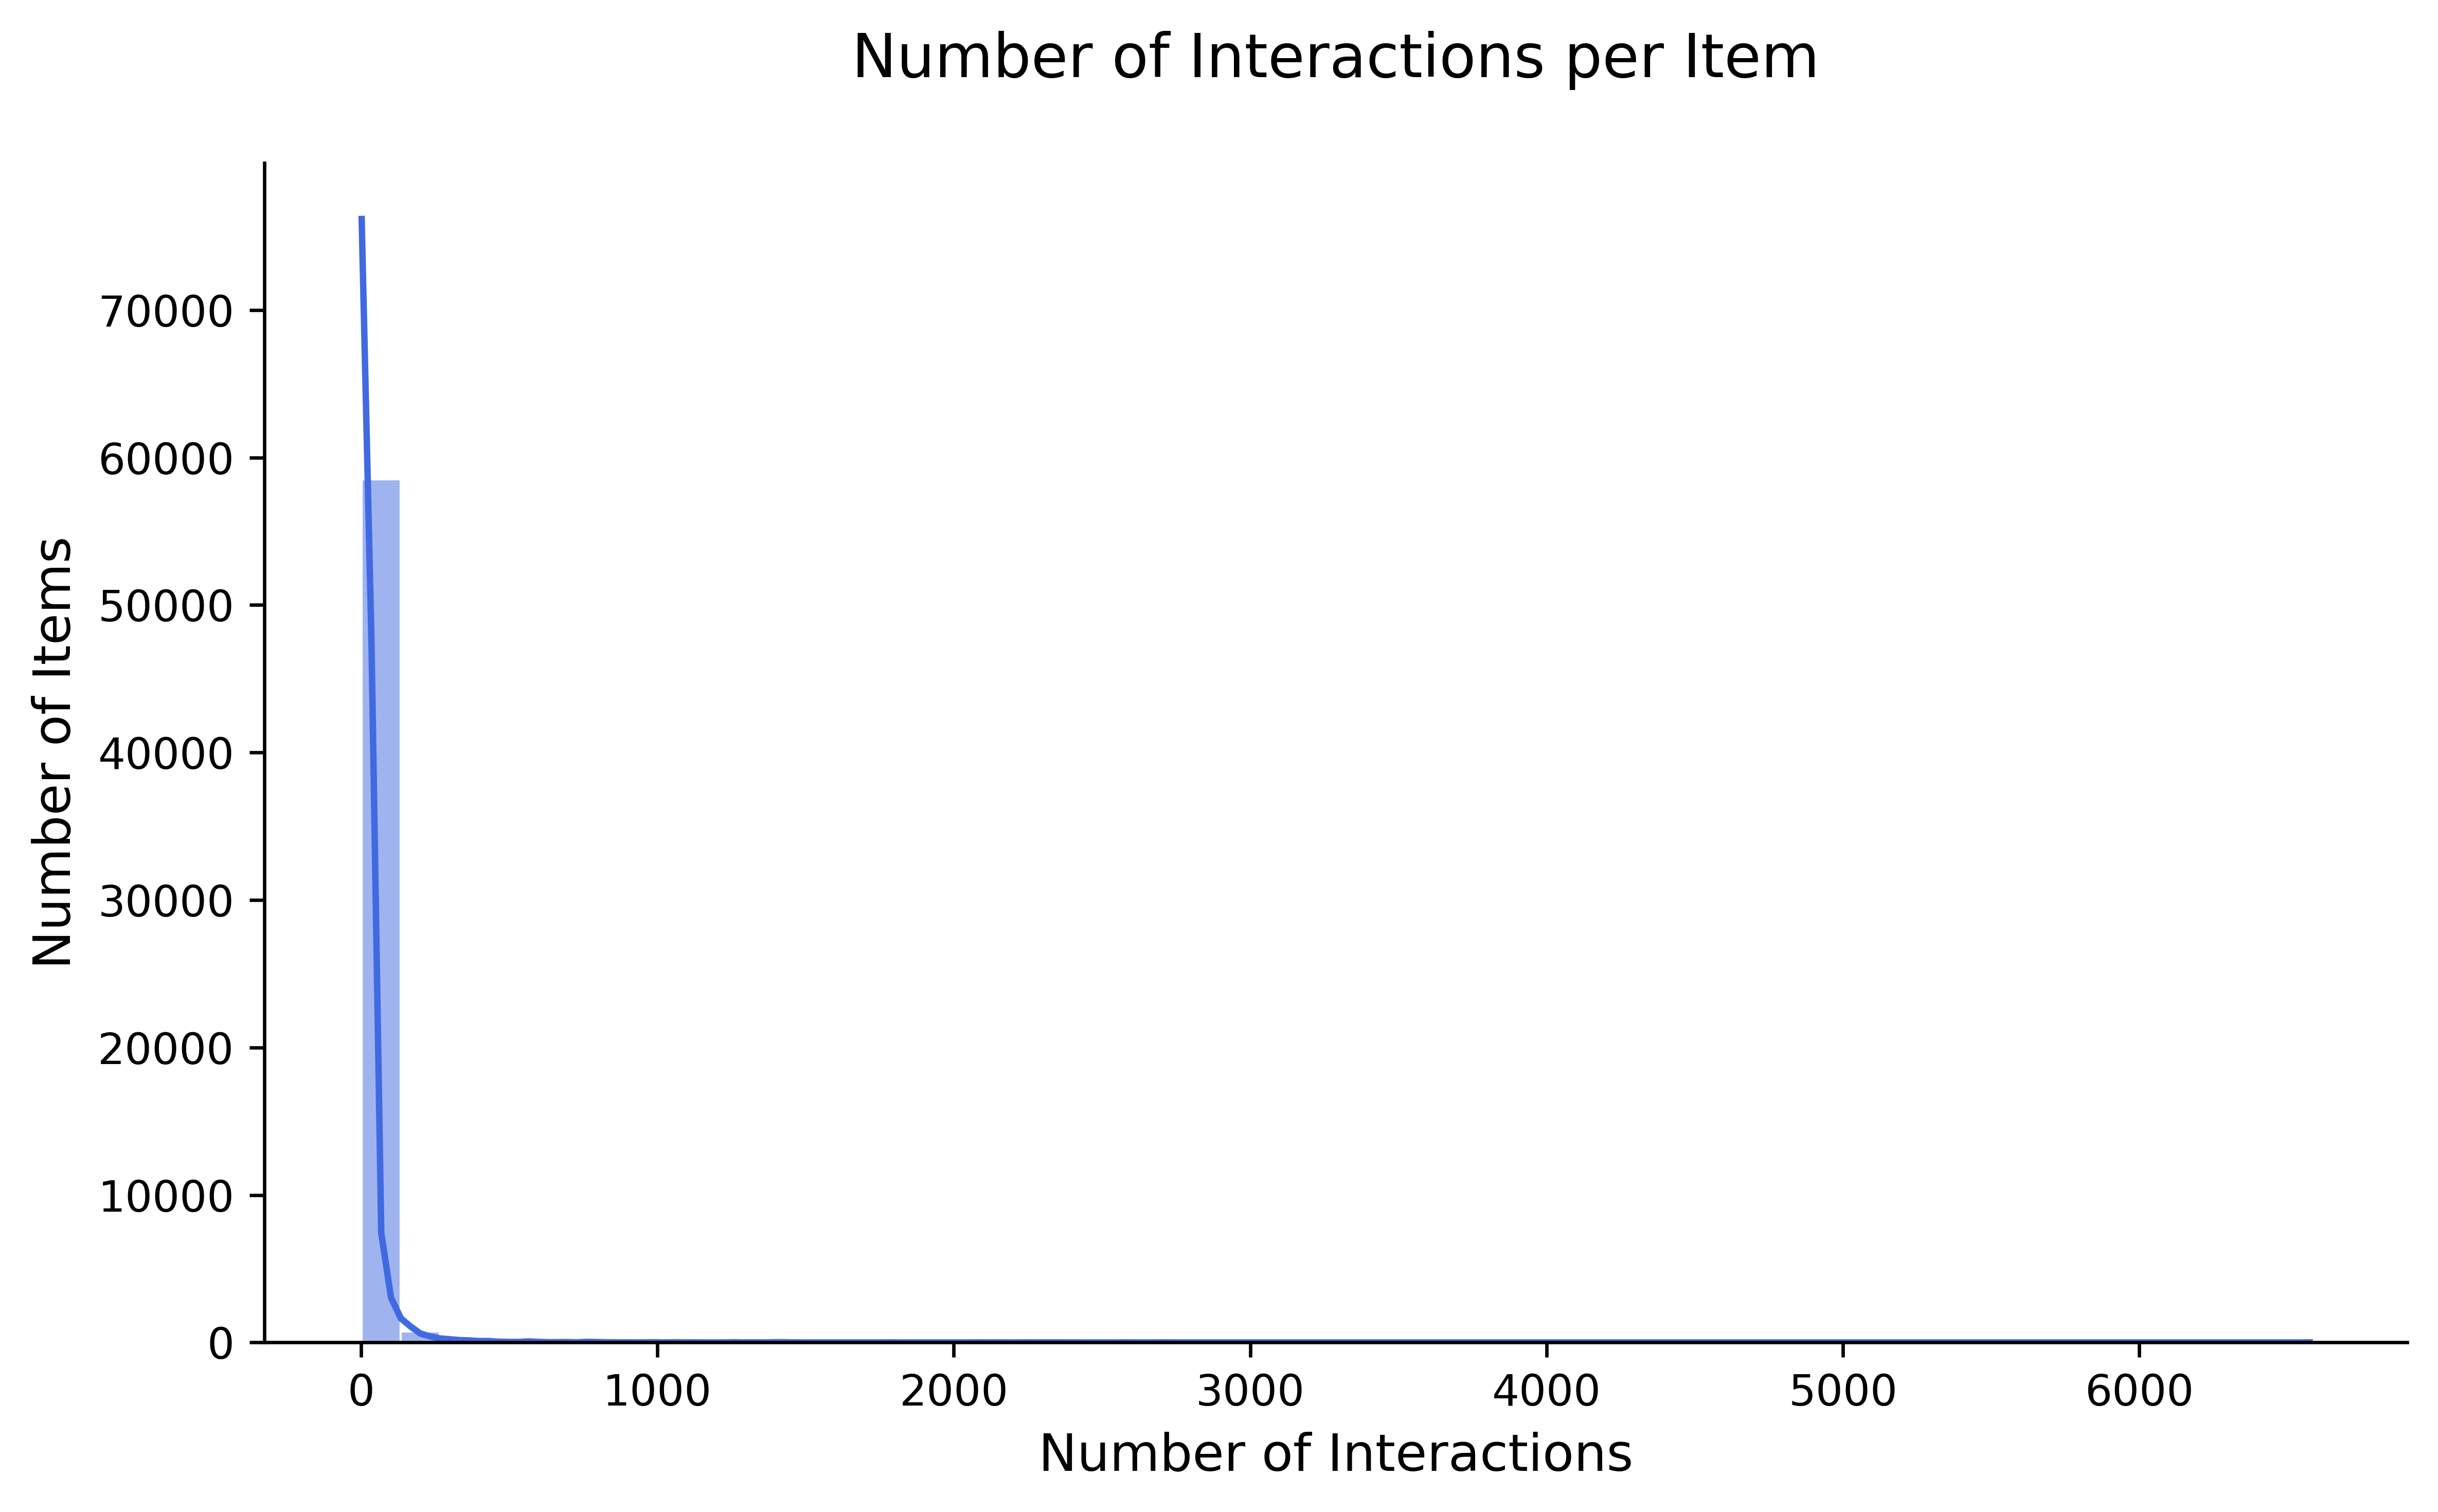

In [16]:
plt.figure(figsize=(8, 5))
plt.rcParams['figure.dpi'] = 600
ax = sns.histplot(item_count,
                 bins=50,
                 color='royalblue',
                 kde=True,
                 edgecolor='white',
                 linewidth=0.5)

plt.title('Number of Interactions per Item', fontsize=14, pad=20)
plt.xlabel('Number of Interactions', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [17]:
item_count.describe()

,user_id
count,59599.000000
mean,25.721875
std,60.665733
min,2.000000
25%,13.000000
50%,16.000000
75%,21.000000
max,6575.000000


The plot and summary statistics reveal that many users rated only a few items. The dataset contains some super-users and super-items as well. To reduce noise and focus on meaningful patterns, we will filter out users with few ratings and items with few interactions.

In [18]:
def filter_items(df, user_col, item_col, item_min_count=20, user_min_count=10):

    print('Filtering items...')

    item_count = df.groupby(item_col)[user_col].nunique()
    item_ids = item_count[item_count >= item_min_count].index
    print(f'Number of items before: {len(item_count)}')
    print(f'Number of items after: {len(item_ids)}')

    print('Filtering users...')

    user_count = df.groupby(user_col)[item_col].nunique()
    user_ids = user_count[user_count >= user_min_count].index
    print(f'Number of users before: {len(user_count)}')
    print(f'Number of users after: {len(user_ids)}')

    print(f'Interactions length before: {len(df)}')
    df = df[df[item_col].isin(item_ids)&df[user_col].isin(user_ids)]
    df.reset_index(inplace=True, drop=True)
    print(f'Interactions length after: {len(df)}')

    return df

In [19]:
df = filter_items(df, USER_COL, ITEM_COL, item_min_count=0, user_min_count=20)

Filtering items...
Number of items before: 59599
Number of items after: 59599
Filtering users...
Number of users before: 151600
Number of users after: 8115
Interactions length before: 1532998
Interactions length after: 470105


Let's load user and item metadata

In [20]:
u_features = pd.read_csv('/content/drive/MyDrive/ML/projects/lightfm/data/users.csv')
i_features = pd.read_csv('/content/drive/MyDrive/ML/projects/lightfm/data/items.csv')
i_features.rename(columns={'id': 'item_id'}, inplace=True)

In [21]:
u_features.head()

,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0
2,3,65_inf,0.0
3,4,18_24,0.0
4,5,35_44,0.0


In [22]:
i_features.head()

,item_id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,95632,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,247906,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,294280,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [23]:
# filter out those users and items that are not present in the interactions dataset
i_features = i_features[i_features[ITEM_COL].isin(df[ITEM_COL])].copy()
u_features = u_features[u_features[USER_COL].isin(df[USER_COL])].copy()

In [24]:
i_features.reset_index(drop=True, inplace=True)
u_features.reset_index(drop=True, inplace=True)

In [25]:
# reassign all user and item IDs

user_idx = df.user_id.astype('category').cat.codes
item_idx = df.item_id.astype('category').cat.codes
user2id = dict(zip(df.user_id, user_idx))
item2id = dict(zip(df.item_id, item_idx))

In [26]:
df.user_id = df.user_id.map(user2id)
df.item_id = df.item_id.map(item2id)
i_features.item_id = i_features.item_id.map(item2id)
u_features.user_id = u_features.user_id.map(user2id)

Train-test split

In [27]:
def train_test_split(clickstream_df, test_quantile=0.8):
    """
    Split clickstream by date.
    """
    clickstream_df = clickstream_df.sort_values(['user_id', 'start_date'])
    test_timepoint = clickstream_df['start_date'].quantile(q=test_quantile, interpolation='nearest')
    test = clickstream_df.query('start_date >= @test_timepoint')
    train = clickstream_df.drop(test.index)

    # make sure there are no cold items or users in the test set
    test = test[test['user_id'].isin(train['user_id'])]
    test = test[test['item_id'].isin(train['item_id'])]

    # select the last item per each user from the test set to evaluate model performance
    # test_full_history = test.sort_values(['user_id', 'start_date']).groupby('user_id')
    # last_item = test_full_history.tail(1)
    # test = test_full_history.head(-1)

    test.reset_index(drop=True, inplace=True)
    train.reset_index(drop=True, inplace=True)
    return train, test

In [28]:
train, test = train_test_split(df, 0.7)

In [29]:
print(f'Unique test users: {test[USER_COL].nunique()}')

Unique test users: 6943


The progress curve plateaus at around the 15% mark, suggesting this threshold can be used to determine which progress range corresponds to liked items.

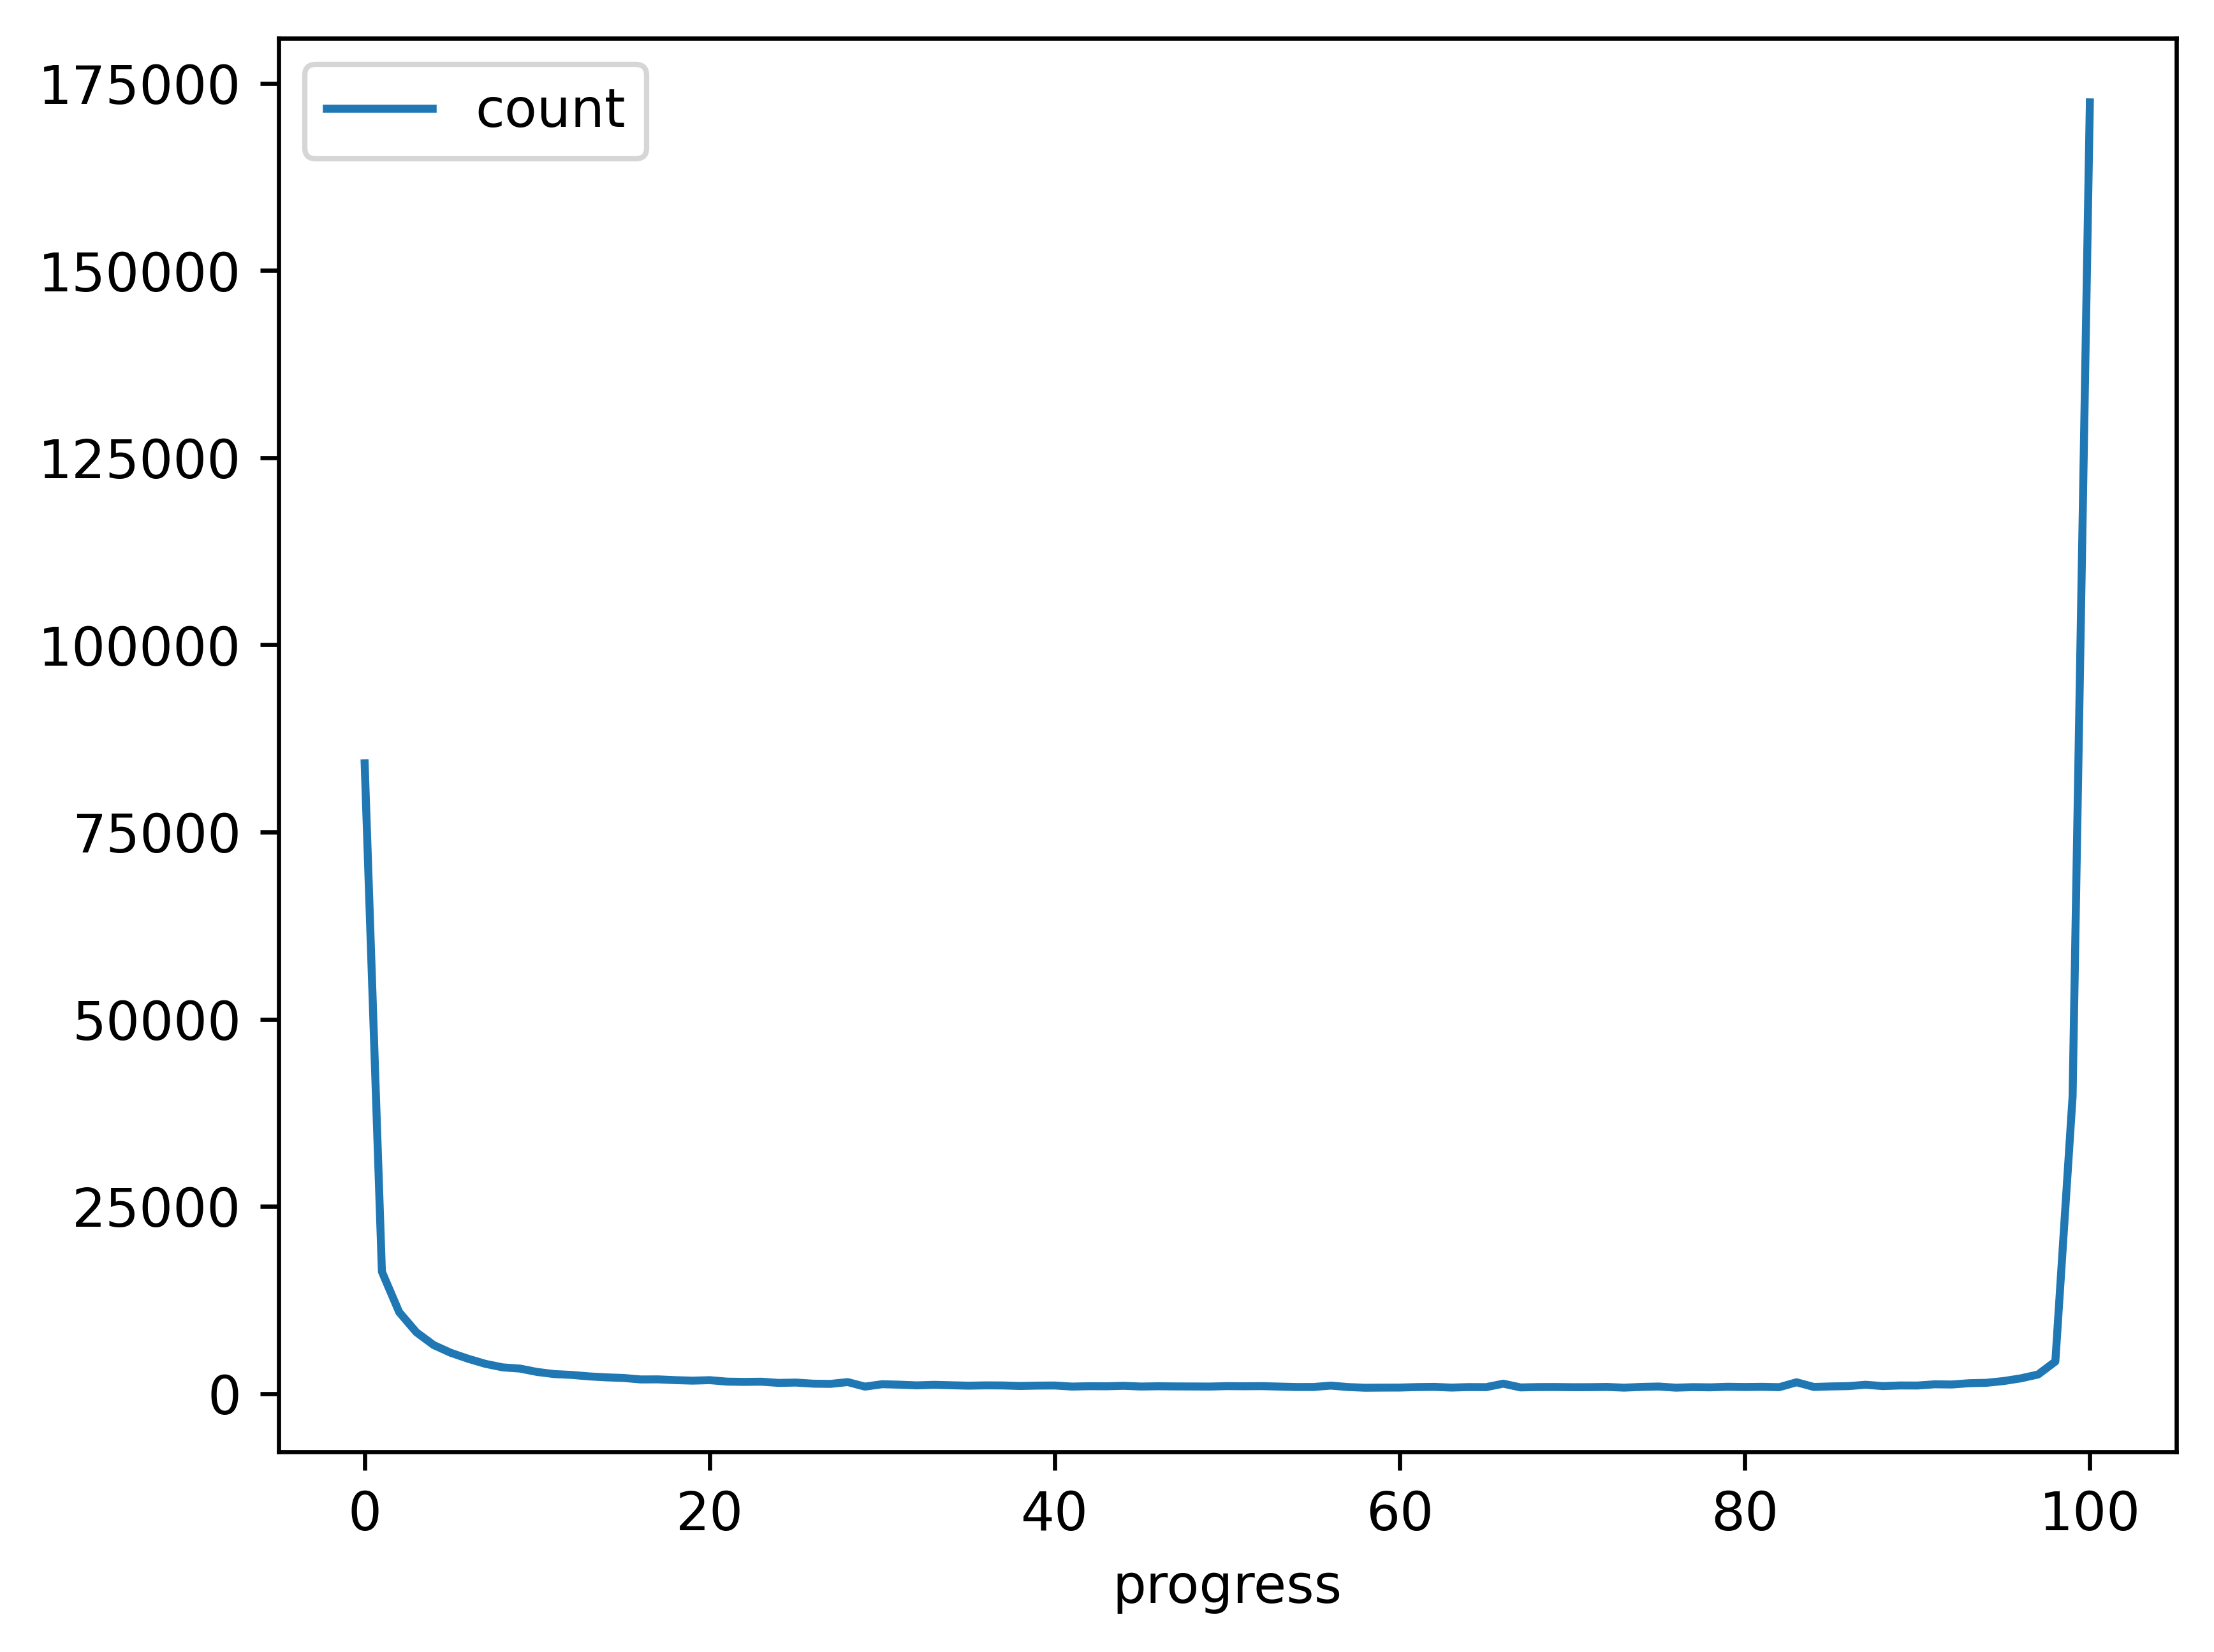

In [30]:
df['progress'].value_counts().reset_index().sort_values('progress').plot(x='progress', y='count');

In [31]:
# use this threshold to filter out books that users likely abandoned early
test = test[test['progress'] >= 15]
test.reset_index(inplace=True, drop=True)

In [32]:
test.head()

,user_id,item_id,progress,rating,start_date
0,0,12187,100,NaN,2019-07-23 00:00:00
1,0,35858,99,NaN,2019-07-24 00:00:00
2,0,20627,100,5.0,2019-07-29 00:00:00
3,0,6561,96,NaN,2019-08-01 00:00:00
4,0,7626,97,NaN,2019-08-03 00:00:00


In [33]:
print(f'Unique test users: {test[USER_COL].nunique()}')

Unique test users: 6624


# LightFM modeling

In this section I compare three LightFM modeling approaches:

- Hybrid model: combines collaborative filtering (interactions) with user-item features

- Collaborative filtering: uses only the interaction matrix

- Features only model: no interaction matrix. Technically speaking, this method is not really suitable for LightFM but I will use for comparison

All models will be evaluated using the precision@20 metric

Let's preprocess user-item features and construct a Dataset class.

### extract user features

In [34]:
u_features.head()

,user_id,age,sex
0,0,18_24,0.0
1,1,25_34,0.0
2,2,18_24,0.0
3,3,25_34,0.0
4,4,35_44,0.0


In [35]:
u_features.set_index(USER_COL, inplace=True)
u_features_list = u_features.apply(lambda feature_values: [f'{feature}_{feature_values[feature]}'\
                                                           for feature in feature_values.index\
                                                           if not pd.isna(feature_values[feature])],
                                   axis=1)
u_features_list = u_features_list.rename('features')

In [36]:
u_features_list

,features
user_id,
0,"[age_18_24, sex_0.0]"
1,"[age_25_34, sex_0.0]"
2,"[age_18_24, sex_0.0]"
3,"[age_25_34, sex_0.0]"
4,"[age_35_44, sex_0.0]"
...,...
8110,"[age_25_34, sex_0.0]"
8111,"[age_25_34, sex_0.0]"
8112,"[age_35_44, sex_0.0]"


In [37]:
user_tags = set(u_features_list.explode().dropna().values)
user_tags

{'age_18_24',
 'age_25_34',
 'age_35_44',
 'age_45_54',
 'age_55_64',
 'age_65_inf',
 'sex_0.0',
 'sex_1.0'}

### extract item features

In [38]:
i_features.head()

,item_id,title,genres,authors,year
0,21706,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,35684,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,16102,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,41941,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,49708,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


Select top 50 genres as item features

In [39]:
i_features_lfm = i_features.copy()
i_features_lfm.set_index(ITEM_COL, inplace=True)
i_features_lfm['reads'] = df.groupby(ITEM_COL)[USER_COL].count()
i_features_lfm['genres'] = i_features_lfm['genres'].str.lower().str.split(',')
i_features_lfm['genres'] = i_features_lfm['genres'].apply(lambda x: x if isinstance(x, list) else [])

In [40]:
i_features_lfm.head()

,title,genres,authors,year,reads
item_id,,,,,
21706,Ворон-челобитчик,"[зарубежные детские книги, сказки, зарубежная ...",Михаил Салтыков-Щедрин,1886,3
35684,Скрипка Ротшильда,"[классическая проза, литература 19 века, русск...",Антон Чехов,1894,30
16102,Испорченные дети,"[зарубежная классика, классическая проза, лите...",Михаил Салтыков-Щедрин,1869,6
41941,Странный человек,"[пьесы и драматургия, литература 19 века]",Михаил Лермонтов,1831,6
49708,Господа ташкентцы,"[зарубежная классика, классическая проза, лите...",Михаил Салтыков-Щедрин,1873,5


In [41]:
genres_count = i_features_lfm[['genres', 'reads']].explode('genres').groupby('genres')['reads'].sum()

In [42]:
genres_count.sort_values(ascending=False)

,reads
genres,
любовное фэнтези,76937
попаданцы,53698
героическое фэнтези,40646
современные любовные романы,40097
современные детективы,39134
...,...
география 9 класс,1
гиа по географии (огэ,1
военное право,1


In [43]:
item_tags = genres_count.sort_values(ascending=False)[:50].index
item_tags[:10]

Index(['любовное фэнтези', 'попаданцы', 'героическое фэнтези',
       'современные любовные романы', 'современные детективы',
       'боевая фантастика', 'боевое фэнтези', 'зарубежные любовные романы',
       'книги про волшебников', 'современная русская литература'],
      dtype='object', name='genres')

In [44]:
def filter_genres(genres_list, valid_genres=None):
    if not genres_list:
        return []
    return [genre for genre in genres_list if genre in valid_genres]

In [45]:
i_features_lfm['features'] = i_features_lfm['genres'].apply(filter_genres, valid_genres=set(item_tags))

In [46]:
i_features_list = i_features_lfm['features']
i_features_list

,features
item_id,
21706,"[зарубежная классика, литература 19 века, русс..."
35684,"[литература 19 века, русская классика]"
16102,"[зарубежная классика, литература 19 века, русс..."
41941,[литература 19 века]
49708,"[зарубежная классика, литература 19 века, русс..."
...,...
7702,[газеты]
54301,[газеты]
21271,[газеты]


### convert into LightFM format

In [47]:
lfm_dataset = LFMDataset()

In [48]:
lfm_dataset.fit_partial(users=df[USER_COL].unique(), items=df[ITEM_COL].unique())
lfm_dataset.fit_partial(user_features=user_tags, item_features=item_tags)

In [49]:
# [0] user id map, [1] user feature map, [2] item id map, [3] item feature map
user_mapping, item_mapping = lfm_dataset.mapping()[0], lfm_dataset.mapping()[2]

In [50]:
inv_user_mapping = {value: key for key, value in user_mapping.items()}
inv_item_mapping = {value: key for key, value in item_mapping.items()}

### transform features

In [51]:
train[USER_COL].max(), train[ITEM_COL].max()

(8114, 54326)

In [52]:
lfm_dataset.interactions_shape()

(8115, 54327)

In [53]:
[[row.item_id, row.features] for row in i_features_list.reset_index().itertuples()][:10]

[[21706, ['зарубежная классика', 'литература 19 века', 'русская классика']],
 [35684, ['литература 19 века', 'русская классика']],
 [16102, ['зарубежная классика', 'литература 19 века', 'русская классика']],
 [41941, ['литература 19 века']],
 [49708, ['зарубежная классика', 'литература 19 века', 'русская классика']],
 [42423, ['литература 19 века']],
 [22929, ['зарубежная классика', 'литература 19 века', 'русская классика']],
 [37581, ['литература 19 века', 'русская классика']],
 [53, ['русская классика']],
 [22566, ['русская классика']]]

In [54]:
[[row.user_id, row.features] for row in u_features_list.reset_index().itertuples()][:10]

[[0, ['age_18_24', 'sex_0.0']],
 [1, ['age_25_34', 'sex_0.0']],
 [2, ['age_18_24', 'sex_0.0']],
 [3, ['age_25_34', 'sex_0.0']],
 [4, ['age_35_44', 'sex_0.0']],
 [5, ['age_18_24', 'sex_0.0']],
 [6, ['age_45_54', 'sex_0.0']],
 [7, ['age_18_24', 'sex_1.0']],
 [8, ['age_25_34', 'sex_1.0']],
 [9, ['age_45_54', 'sex_0.0']]]

In [55]:
sparse_i_features = lfm_dataset.build_item_features([[row.item_id, row.features] for row in i_features_list.reset_index().itertuples()])
sparse_u_features = lfm_dataset.build_user_features([[row.user_id, row.features] for row in u_features_list.reset_index().itertuples()])

In [56]:
sparse_i_features.shape # n_items + n_item_features

(54327, 54377)

In [57]:
sparse_u_features.shape # n_users + n_user_features

(8115, 8123)

In [58]:
sparse_u_features.todense()

matrix([[0.33333334, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.33333334, 0.        , ..., 0.        , 0.33333334,
         0.        ],
        [0.        , 0.        , 0.33333334, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)

### transform interactions

In [59]:
(interactions, weights) = lfm_dataset.build_interactions([(row.user_id, row.item_id, row.progress) for row in train.itertuples()])

In [60]:
interactions.shape, interactions.data, weights.data

((8115, 54327),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 array([27., 54., 85., ...,  5., 39.,  3.], dtype=float32))

## Train models

In [61]:
# Hybrid model
%%time
lightfm = LightFM(no_components=50, loss='warp', random_state=77)
lightfm.fit(interactions,
            user_features=sparse_u_features,
            item_features=sparse_i_features,
            epochs=40,
            num_threads=8)

CPU times: user 1min 46s, sys: 366 ms, total: 1min 46s
Wall time: 1min 12s


In [62]:
# Interactions only model
%%time
lightfm_interactions = LightFM(no_components=50, loss='warp', random_state=77)
lightfm_interactions.fit(interactions, user_features=None, item_features=None, epochs=40, num_threads=8)

CPU times: user 1min 6s, sys: 268 ms, total: 1min 6s
Wall time: 43.7 s


In [63]:
# Features only model (build interaction and weight matrices filled with 0)
(interactions, weights) = lfm_dataset.build_interactions([(row.user_id, row.item_id, 0) for row in train.itertuples()])
interactions_0 = csc_matrix(interactions.shape, dtype=float)

In [64]:
interactions_0.shape, interactions_0.data, weights.data

((8115, 54327),
 array([], dtype=float64),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [65]:
%%time
lightfm_features = LightFM(no_components=50, loss='warp', random_state=77)
lightfm_features.fit(interactions=interactions_0,
                     user_features=sparse_u_features,
                     item_features=sparse_i_features,
                     epochs=40,
                     num_threads=8)

CPU times: user 347 ms, sys: 19 ms, total: 366 ms
Wall time: 446 ms


## Evaluate model quality on the test set using the precision@20 metric

In [66]:
def predict(test, model, k=20, use_features=True):

  predictions = {}

  for user in tqdm(test.user_id.unique()):

    if use_features:
      user_preds = model.predict(user_ids=user_mapping[user], item_ids=sorted(item_mapping.values()), user_features=sparse_u_features, item_features=sparse_i_features)
    else:
      user_preds = model.predict(user_ids=user_mapping[user], item_ids=sorted(item_mapping.values()), user_features=None, item_features=None)

    ids = np.argpartition(user_preds, -k)[-k:]
    rel = user_preds[ids]
    res = pd.DataFrame(zip(ids, rel), columns=['item_id', 'relevance'])
    res['item_id'] = res['item_id'].map(inv_item_mapping)
    recommended_items = res['item_id'].values

    predictions[int(user)] = recommended_items

  return predictions

In [67]:
def precision_at_K(ground_truth, predictions, K=20):
    precisions = []
    for user_id in tqdm(ground_truth, desc=f"Calculating precision@{K}"):
        if user_id in predictions:
            overlap = len(set(ground_truth[user_id]) & set(predictions[user_id]))
            precisions.append(overlap / K)
    return round(float(np.mean(precisions)), 4)

In [68]:
test_data = test.groupby('user_id')['item_id'].apply(np.array).reset_index()
test_data = test_data.set_index('user_id')['item_id'].to_dict()

In [69]:
lightfm_preds = predict(test, lightfm, k=20)

100%|██████████| 6624/6624 [08:58<00:00, 12.29it/s]


In [70]:
lightfm_eval = precision_at_K(test_data, lightfm_preds)

Calculating precision@20: 100%|██████████| 6624/6624 [00:00<00:00, 143563.95it/s]


In [71]:
lightfm_interactions_preds = predict(test, lightfm_interactions, 20, False)

100%|██████████| 6624/6624 [07:56<00:00, 13.90it/s]


In [72]:
lightfm_interactions_eval = precision_at_K(test_data, lightfm_interactions_preds)

Calculating precision@20: 100%|██████████| 6624/6624 [00:00<00:00, 138379.82it/s]


In [73]:
lightfm_features_preds = predict(test, lightfm_features, k=20)

100%|██████████| 6624/6624 [08:50<00:00, 12.49it/s]


In [74]:
lightfm_features_eval = precision_at_K(test_data, lightfm_features_preds)

Calculating precision@20: 100%|██████████| 6624/6624 [00:00<00:00, 71882.08it/s]


In [75]:
results = [
    ["Model type", "Precision@20"],
    ["Hybrid (interactions + features)", f"{lightfm_eval}"],
    ["Interactions only", f"{lightfm_interactions_eval}"],
    ["Features only", f"{lightfm_features_eval}"]
]

print("\nModel Performance Comparison\n")
print(tabulate(results, headers="firstrow", tablefmt="pretty"))


Model Performance Comparison

+----------------------------------+--------------+
|            Model type            | Precision@20 |
+----------------------------------+--------------+
| Hybrid (interactions + features) |    0.0116    |
|        Interactions only         |    0.0112    |
|          Features only           |    0.0001    |
+----------------------------------+--------------+


The results indicate that the best quality is achieved using a hybrid LightFM model which combines collaborative filtering with user and item features. It performs slightly better than the interactions only model. However, the difference is not so evident in this case, and I've found an interesting discussion [here](https://github.com/lyst/lightfm/issues/486) about cases when a LightFM CF model can outperform a hybrid model. I believe this may also depend on the features used because a hybrid model requires a more nuanced approach. In this research, the features describing simple user demographics such as age and top-50 genres might not be very informative, and the model would probably benefit from additional feature engineering. The features only model hardly learns anything, which proves that interactions play a crucial part in the LightFM framework.